我们采用的测试环境是 CartPole-v0，其状态空间相对简单，只有 4 个变量，因此网络结构的设计也相对简单：采用一层 128 个神经元的全连接并以 ReLU 作为激活函数。当遇到更复杂的诸如以图像作为输入的环境时，我们可以考虑采用深度卷积神经网络。

rl_utils库，它包含一些特定的函数，如绘制移动平均曲线、计算优势函数等

In [3]:
import random
import gym
import numpy as np
import collections
from tqdm import tqdm # tqdm库显示训练进度条
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import rl_utils

In [4]:
# 首先定义经验回放池的类，主要包括加入数据、采样数据两大函数

class ReplayBuffer:
    # 经验回放池
    def __init__(self, capacity):
        self.buffer = collections.deque(maxlen = capacity)  # 队列,先进先出

    def add(self, state, action, reward, next_state, done):  # 将（状态、动作、奖励、下一状态）存储到回放缓冲区中
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):  # 从buffer中采样数据,数量为batch_size
        transitions = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = zip(*transitions) # 将一个包含多个元素的列表（或其他可迭代对象）转换为多个元组
        return np.array(state), action, reward, np.array(next_state), done

    def size(self):  # 目前buffer中数据的数量
        return len(self.buffer)

In [5]:
# 然后定义一个只有一层隐藏层的 Q 网络

class Qnet(torch.nn.Module):
    # 只有一层隐藏层的Q网络
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(Qnet, self).__init__()
        # 定义两个全连接层
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, action_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))  # 隐藏层使用ReLU激活函数
        return self.fc2(x)

In [6]:
# 有了上述基本组件之后，接来下开始实现 DQN 算法

class DQN:
    # DQN算法
    def __init__(self, state_dim, hidden_dim, action_dim, learning_rate, gamma, epsilon, target_update, device):
        self.action_dim = action_dim
        self.q_net = Qnet(state_dim, hidden_dim, self.action_dim).to(device) # Q 网络
        self.target_q_net = Qnet(state_dim, hidden_dim, self.action_dim).to(device) # 目标网络
        self.optimizer = torch.optim.Adam(self.q_net.parameters(), lr=learning_rate) # 使用Adam优化器
        self.gamma = gamma  # 折扣因子
        self.epsilon = epsilon  # epsilon-贪婪策略
        self.target_update = target_update  # 目标网络更新频率
        self.count = 0  # 计数器,记录更新次数
        self.device = device

    def take_action(self, state):  # epsilon-贪婪策略采取动作
        if np.random.random() < self.epsilon:
            action = np.random.randint(self.action_dim) # 选择随机动作
        else:
            state = torch.tensor([state], dtype=torch.float).to(self.device)
            action = self.q_net(state).argmax().item() # 到Q网络中执行前向计算，选择Q值最大的动作
        return action

    def update(self, transition_dict):
        # 将经验回放缓存中的元素转换成 PyTorch 张量
        states = torch.tensor(transition_dict['states'], dtype = torch.float).to(self.device)
        actions = torch.tensor(transition_dict['actions']).view(-1, 1).to(self.device)
        rewards = torch.tensor(transition_dict['rewards'], dtype = torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'], dtype = torch.float).to(self.device)
        dones = torch.tensor(transition_dict['dones'], dtype = torch.float).view(-1, 1).to(self.device)

        # 计算当前状态下选择的动作的 Q 值
        q_values = self.q_net(states).gather(1, actions)
        # 下个状态的最大Q值
        max_next_q_values = self.target_q_net(next_states).max(1)[0].view(-1, 1)
        # 计算TD误差目标，dones表示是否达到了终止状态
        q_targets = rewards + self.gamma * max_next_q_values * (1 - dones)
        # 使用均方误差作为 DQN 的损失函数
        dqn_loss = torch.mean(F.mse_loss(q_values, q_targets)) 
        # 将梯度清零，避免梯度累积影响下一次更新
        self.optimizer.zero_grad()  
        # 反向传播更新参数
        dqn_loss.backward()  
        # 执行参数更新
        self.optimizer.step()
        
        # 每隔一定步数更新一次目标网络
        if self.count % self.target_update == 0:
            self.target_q_net.load_state_dict(self.q_net.state_dict()) 
        self.count += 1

In [7]:
# 定义超参
lr = 2e-3
num_episodes = 500
hidden_dim = 128
gamma = 0.98
epsilon = 0.01
target_update = 10
buffer_size = 10000
minimal_size = 500
batch_size = 64
# device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device = torch.device("cpu")

# 创建环境
env_name = 'CartPole-v0'
env = gym.make(env_name)
random.seed(0)
np.random.seed(0)
env.seed(0)
torch.manual_seed(0)

# 创建经验回放池和DQN智能体
replay_buffer = ReplayBuffer(buffer_size)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
agent = DQN(state_dim, hidden_dim, action_dim, lr, gamma, epsilon, target_update, device)

return_list = [] # 记录每个episode的回报值
for i in range(10): # 训练分为10轮，每轮训练num_episodes/10次
    with tqdm(total=int(num_episodes / 10), desc='Iteration %d' % i) as pbar:
        for i_episode in range(int(num_episodes / 10)):
            episode_return = 0 # 用于记录每个训练周期的回报值
            state = env.reset() # 重置环境，获取起始状态
            done = False
            while not done: # 直到智能体达到终止状态
                action = agent.take_action(state)  # 根据当前状态选择动作
                next_state, reward, done, _ = env.step(action) # 执行动作，获取下一状态、奖励、是否终止
                replay_buffer.add(state, action, reward, next_state, done) # 将当前状态、动作、奖励、下一个状态和终止标志添加到经验回放池中
                state = next_state # 更新状态
                episode_return += reward # 把奖励值累计到回报值中
                if replay_buffer.size() > minimal_size: # 当经验回放池数据的数量超过一定值后,才进行Q网络训练
                    b_s, b_a, b_r, b_ns, b_d = replay_buffer.sample(batch_size) # # 从经验回放池中随机采样一批数据，并将其转换为字典形式
                    transition_dict = {
                        'states': b_s,
                        'actions': b_a,
                        'next_states': b_ns,
                        'rewards': b_r,
                        'dones': b_d
                    }
                    agent.update(transition_dict) # 使用采样得到的数据更新 DQN 网络
            return_list.append(episode_return) # 记录本次训练周期的回报值
            if (i_episode + 1) % 10 == 0:
                pbar.set_postfix({
                    'episode':
                    '%d' % (num_episodes / 10 * i + i_episode + 1),
                    'return':
                    '%.3f' % np.mean(return_list[-10:])
                })
            pbar.update(1)

/opt/anaconda3/envs/welldone/lib/python3.9/site-packages/gym/envs/registration.py:593: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(
/opt/anaconda3/envs/welldone/lib/python3.9/site-packages/gym/core.py:329: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/opt/anaconda3/envs/welldone/lib/python3.9/site-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/opt/anaconda3/envs/welldone/lib/python3.9/site-packages/gym/core.py:268: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated an

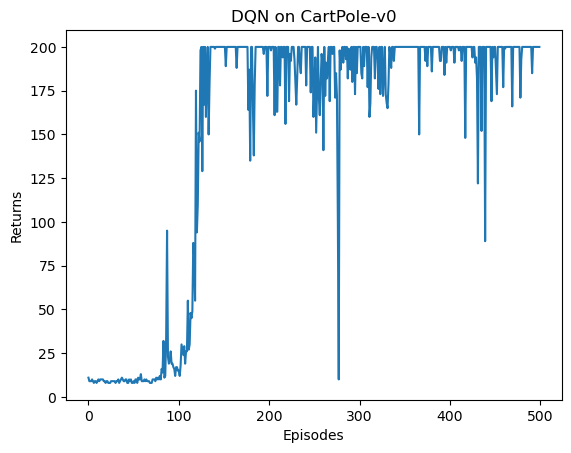

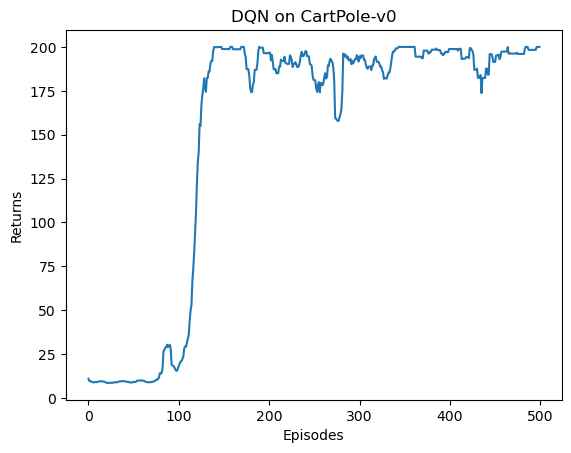

In [8]:
episodes_list = list(range(len(return_list))) # 生成训练周期序号列表
plt.plot(episodes_list, return_list) # 绘制训练周期和回报值之间的折线图
plt.xlabel('Episodes') # 设置x轴标签
plt.ylabel('Returns') # 设置y轴标签
plt.title('DQN on {}'.format(env_name)) # 设置图表标题
plt.show() # 显示图表

mv_return = rl_utils.moving_average(return_list, 9) # 对回报值进行移动平均处理，平均窗口大小为9
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('DQN on {}'.format(env_name))
plt.show()

In [9]:
class ConvolutionalQnet(torch.nn.Module):
    ''' 加入卷积层的Q网络 '''
    def __init__(self, action_dim, in_channels=4):
        super(ConvolutionalQnet, self).__init__()
        self.conv1 = torch.nn.Conv2d(in_channels, 32, kernel_size=8, stride=4)
        self.conv2 = torch.nn.Conv2d(32, 64, kernel_size=4, stride=2)
        self.conv3 = torch.nn.Conv2d(64, 64, kernel_size=3, stride=1)
        self.fc4 = torch.nn.Linear(7 * 7 * 64, 512)
        self.head = torch.nn.Linear(512, action_dim)

    def forward(self, x):
        x = x / 255
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.fc4(x))
        return self.head(x)